<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance4_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 **Avance 4. Modelos alternativos**: Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión. Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Mayo 26 del 2024

In [62]:
#!pip install scikeras

In [63]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
#from scikeras.wrappers import KerasRegressor


👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [64]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1



---

☝**NOTA:** En este entregable iniciaremos aplicando los ajustes detectados en los entregables anteriores, referentes a la depuración de los datos y la ingeniería de características. Por lo tanto, la creación del baseline solicitando en esta entrega se identificará más adelante en la sección 2 del presente notebook.


---




---


👣 **SECCIÓN 1:** Limpieza y ajuste del conjunto de datos.



---



In [65]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [66]:
#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

In [67]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo.head()

,Fecha Consumo,Tipo Empleado,Porcentaje apoyo
0,2021-01-03,Operativo,0
1,2021-01-03,Administrativo,90
2,2021-01-03,Operativo,0
3,2021-01-03,Operativo,90
4,2021-01-03,Administrativo,0


**pd.get_dummies():** Esta función se utilizó para convertir las variables categóricas Tipo Empleado y Porcentaje apoyo en un conjunto de variables indicadoras (también llamadas variables dummy). Es una técnica comúnmente usada en la preparación de datos para modelos de aprendizaje automático, particularmente útil cuando se trata con modelos que requieren entradas numéricas exclusivamente.

In [68]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfCasinoConsumo, columns=['Tipo Empleado',  'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,False,False,True,True,False,False,False
1,2021-01-03,True,False,False,False,False,True,False
2,2021-01-03,False,False,True,True,False,False,False
3,2021-01-03,False,False,True,False,False,True,False
4,2021-01-03,True,False,False,True,False,False,False


In [69]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0


In [70]:
dfCasinoAlmuerzosCodificado

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
884610,2024-03-21,0,0,1,0,0,1,0
884611,2024-03-22,0,0,1,0,0,1,0
884612,2024-03-23,0,0,1,0,0,1,0
884613,2024-03-26,0,0,1,0,0,1,0


In [71]:
# Agrupar por 'Fecha' y realizar las agregaciones necesarias para olumnas codificadas como dummies con la función agg()
dfAlmuerzoAgrupado = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({
    'Tipo Empleado_Administrativo': 'sum',
    'Tipo Empleado_Aprendices': 'sum',
    'Tipo Empleado_Operativo': 'sum',
    'Porcentaje apoyo_0': 'sum',
    'Porcentaje apoyo_30': 'sum',
    'Porcentaje apoyo_90': 'sum',
    'Porcentaje apoyo_100': 'sum'
}).reset_index()

In [72]:
# Agregar una nueva columna con el conteo de registros por fecha
dfAlmuerzoAgrupado['Cantidad Almuerzos'] = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').size().values

In [73]:
# Convertir fechas a formato datetime
dfAlmuerzoAgrupado['Fecha Consumo'] = pd.to_datetime(dfAlmuerzoAgrupado['Fecha Consumo'])

# Nos aseguramos de que el DataFrame esté ordenado por fecha para que cualquier operación
# o visualización a realizar con los datos siga el orden cronológico correcto.
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.sort_values('Fecha Consumo')

# Configurar la fecha como el índice
dfAlmuerzoAgrupado.set_index('Fecha Consumo', inplace=True)
dfAlmuerzoAgrupado.index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12',
               ...
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha Consumo', length=1181, freq=None)

In [74]:
fecha_inicio = dfAlmuerzoAgrupado.index.min()
fecha_fin = dfAlmuerzoAgrupado.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
# Reindexar el DataFrame
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.reindex(rango_fechas)

dfAlmuerzoAgrupado.fillna(0,inplace=True)

# Seleccionar el valor de una columna específica en una fecha específica usando at
# Especifica la fecha que deseas filtrar
fecha_especifica = '2022-01-01'

# Convertir la fecha específica a tipo datetime
fecha_especifica = pd.to_datetime(fecha_especifica)

# Filtrar el DataFrame para la fecha específica
try:
    registro_filtrado = dfAlmuerzoAgrupado.loc[fecha_especifica]
    print(f"Registro para la fecha {fecha_especifica.date()}:\n{registro_filtrado}")
except KeyError:
    print(f"No hay registros para la fecha {fecha_especifica.date()}")

dfAlmuerzoAgrupado.info()


Registro para la fecha 2022-01-01:
Tipo Empleado_Administrativo    0.0
Tipo Empleado_Aprendices        0.0
Tipo Empleado_Operativo         0.0
Porcentaje apoyo_0              0.0
Porcentaje apoyo_30             0.0
Porcentaje apoyo_90             0.0
Porcentaje apoyo_100            0.0
Cantidad Almuerzos              0.0
Name: 2022-01-01 00:00:00, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1184 entries, 2021-01-03 to 2024-03-31
Freq: D
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo Empleado_Administrativo  1184 non-null   float64
 1   Tipo Empleado_Aprendices      1184 non-null   float64
 2   Tipo Empleado_Operativo       1184 non-null   float64
 3   Porcentaje apoyo_0            1184 non-null   float64
 4   Porcentaje apoyo_30           1184 non-null   float64
 5   Porcentaje apoyo_90           1184 non-null   float64
 6   Porcentaje apoyo_100      

In [75]:
# Variable endógena (consumo)
dfendog = dfAlmuerzoAgrupado['Cantidad Almuerzos']

# Variables exógenas
#dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo']]

In [76]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(dfAlmuerzoAgrupado) * 0.7)
train_endog1 = dfendog[:train_size]
test_endog1 = dfendog[train_size:]

train_exog = dfexog[:train_size]
test_exog = dfexog[train_size:]

In [77]:
train_endog = train_endog1.to_frame()
test_endog = test_endog1.to_frame()


---


# 🔖 **Rúbrica - Criterio: Comparativa**


---



---

📚 Basados en la investigación realizada referente a los modelos recomendados para la predicción de la variable objetivo en función de un conjunto de datos con componentes estacionales y variables exógenas, utilizaremos los siguientes modelos para realizar la comparación y seleccionar los dos que nos muestren el mejor rendimiento:
* SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)
* ARIMA (AutoRegressive Integrated Moving Average)
* Regresión Lineal (Linear Regression)
* Árbol de Regresión (Regression Tree)
* Redes Neuronales (Neural Networks)
* SVM (Support Vector Machines)

De igual forma, utilizaremos el dataframe '**dfmetricas**' para almacenar los rendimientos de las métricas clave de cada modelo y así realizar una comparación objetiva al final del ejercicio.


---

In [78]:
#Creamos el dataframe para almacenar las diferentes metricas calculadas para cada uno de los 6 modelos
data  = {'Modelo': ['SARIMAX','ARIMA','REGRESIÓN LINEAL','ARBOL DE REGRESIÓN','REDES NEURONALES','SVM'],'Metrica 1': ['WMAE','MAE','MSE','MSE','MBE','MAE'],'Valor 1':[0,0,0,0,0,0],'Metrica 2': ['MBE','MAPE','R2','R2','LOSS','WMAE'],'Valor 2':[0,0,0,0,0,0] }
dfmetricas = pd.DataFrame(data)
print("*******************************************************************************")
print("Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:")
print("*******************************************************************************")

dfmetricas

*******************************************************************************
Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:
*******************************************************************************


,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,0,MBE,0
1,ARIMA,MAE,0,MAPE,0
2,REGRESIÓN LINEAL,MSE,0,R2,0
3,ARBOL DE REGRESIÓN,MSE,0,R2,0
4,REDES NEURONALES,MBE,0,LOSS,0
5,SVM,MAE,0,WMAE,0




---


👣**Creación de Modelos**: Iniciamos con la creación y ejecución de los modelos mencionados.

🦾 **Modelo 1: SARIMAX**


---



In [79]:
#Definimos los parámetros a utilizar en SARIMAX siguiendo los hallazgos de los entregables anteriores
p, d, q = 1, 2, 1
#P, D, Q, s = 1, 1, 1, 12 #Estos serán nuestros parámetros estacionales
P, D, Q, s = 1, 1, 1, 7 #Estos serán nuestros parámetros estacionales

#Entrenamos el modelo
Modelo_SARIMAX = sm.tsa.SARIMAX(train_endog, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
Resultados_SARIMAX = Modelo_SARIMAX.fit()

#Observamos los datos de resumen del modelo
print(Resultados_SARIMAX.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                Cantidad Almuerzos   No. Observations:                  828
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 7)   Log Likelihood                 282.038
Date:                           Tue, 28 May 2024   AIC                           -548.075
Time:                                   20:00:51   BIC                           -510.410
Sample:                               01-03-2021   HQIC                          -533.622
                                    - 04-10-2023                                         
Covariance Type:                             opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Tipo Empleado_Aprendices         1.0000   5.54e-05    1.8e+04      0.000       1.000  

In [80]:
#Definimos el rango de fechas en nuestro conjunto de pruebas para la predicción con el modelo
Fecha_Inicio = test_endog.index[0]  #Fecha desde
Fecha_Fin =  test_endog.index[-1]  #Fecha hasta

In [81]:
#Realizamos las predicciones
Prediccion_SARIMAX = Resultados_SARIMAX.get_prediction(start=Fecha_Inicio, end=Fecha_Fin, exog=test_exog)
Prediccion_Final_SARIMAX = Prediccion_SARIMAX.predicted_mean

#Definimos los intervalos de confianza
Prediccion_CI_SARIMAX = Prediccion_SARIMAX.conf_int()

In [82]:
#Visualizamos las predicciones generadas con el modelo SARIMAX, para ello creamos un dataframe comparando
#las predicciones con los datos reales.
dfComparativoPredSARIMAX = pd.concat([test_endog, Prediccion_Final_SARIMAX], axis=1)
dfComparativoPredSARIMAX.columns = ['Real', 'Predicción']
print("******************************************************")
print("Las predicciones generadas con el modelo SARIMAX son:")
print("******************************************************")
dfComparativoPredSARIMAX

******************************************************
Las predicciones generadas con el modelo SARIMAX son:
******************************************************


,Real,Predicción
2023-04-11,700.0,698.093147
2023-04-12,728.0,726.087080
2023-04-13,747.0,745.082179
2023-04-14,707.0,705.076472
2023-04-15,608.0,606.070722
...,...,...
2024-03-27,1173.0,1168.597886
2024-03-28,672.0,667.590085
2024-03-29,612.0,607.581477
2024-03-30,593.0,588.572826


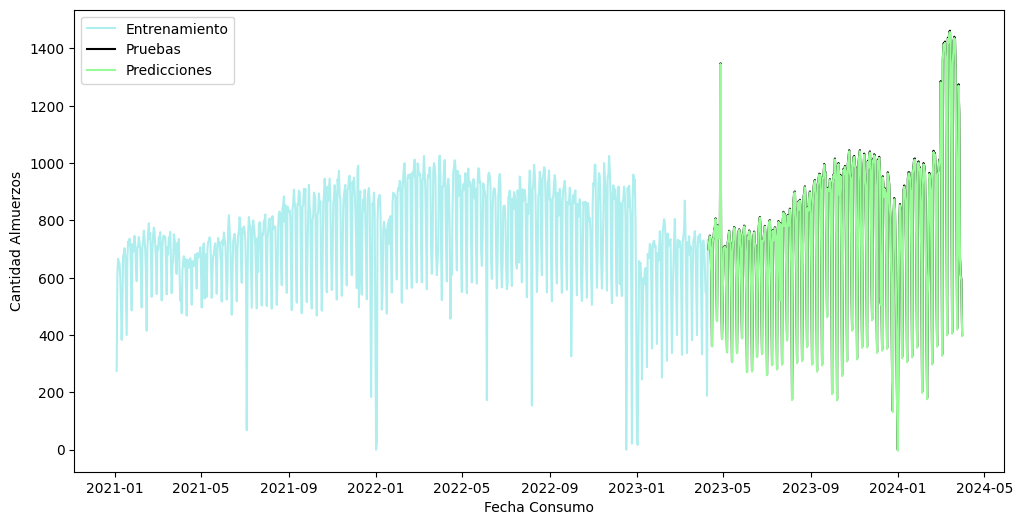

In [83]:
#Graficamos las predicciones para realizar un análisis visual
plt.figure(figsize=(12, 6))
plt.plot(train_endog, label='Entrenamiento', color='paleturquoise')
plt.plot(test_endog, label='Pruebas', color='black')
plt.plot(Prediccion_Final_SARIMAX, label='Predicciones', color='palegreen')
plt.fill_between(Prediccion_CI_SARIMAX.index, Prediccion_CI_SARIMAX.iloc[:, 0], Prediccion_CI_SARIMAX.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.legend()
plt.show()

---

🔢**Métricas:** calcularemos a continuación las diferentes métricas recomendadas para el modelo SARIMAX. Sin embargo, nos enfocaremos en las métricas MBE y WMAE definidas en nuestro entregable anterior como parámetros propuesto para afinamiento del modelo.

---

In [97]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(test_endog, Prediccion_Final_SARIMAX)
RMSE = np.sqrt(mean_squared_error(test_endog, Prediccion_Final_SARIMAX))

#Calculamos MBE
mbe = (Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos']).mean()

#Calculamos WMAE
errors = Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos'].mean()
Pesos = np.where(errors > 0, 1, 2)
#Pesos =  np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos'])
wmae = np.sum(Pesos * np.abs(errors)) / np.sum(Pesos)
#wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

print(f'**********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels):')
print(f'**********************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'MBE: {mbe}')
print(f'WMAE: {wmae}')


**********************************************
Métricas para el modelo SARIMAX (statsmodels):
**********************************************
MAE: 3.0845343188899226
RMSE: 3.170479661896986
MBE: -3.0845343188899226
WMAE: 214.47556755943683


In [98]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[0,'Valor 1'] = wmae
dfmetricas.at[0,'Valor 2'] = mbe

---


🦾 **Modelo 6: SUPPORT VECTOR MACHINE (SVM)**


---

In [99]:
#Antes de iniciar con nuestro modelo SVM preparamos los datos
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado

#Separamos las variables exógenas (X) de la endógena (y)
X = dfAlmuerzoAgrupado1[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

#Dividimos nuestros datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
#Ahora vamos a crear un pipeline para escalar los datos y entrenar así el modelo SVM
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))

#Entrenamos el modelo con los datos de entrenamiento
pipeline.fit(X_train, y_train)

#Realizamos las predicciones con los datos de prueba
Predicciones_SVM = pipeline.predict(X_test)

#Visualizamos las predicciones de nuestro modelo SVM
print("*************************************************")
print("Las predicciones generadas con el modelo SVM son:")
print("*************************************************")
Predicciones_SVM

*************************************************
Las predicciones generadas con el modelo SVM son:
*************************************************


array([ 908.1212929 ,  872.80912402,  613.66343547,  701.02228932,
        996.52656515,  978.04630414,  629.62075522,  538.62041687,
        905.48509759,  828.73137137,  771.57785892,  157.26936495,
        663.40911762,  135.64835427,  809.71442562,  747.91462006,
        800.13230545,  876.66428724,  727.88321812,  514.11011979,
        907.70648486,  621.12465489,  651.86996511,  787.11887666,
        575.25099339,  867.92859911,  879.07673093,  530.30759789,
        517.25606465,  815.33077481,  691.08017167,  697.93616518,
        976.74657377,  896.16525402,  866.38105822,  691.09537963,
        363.29686861,  970.98147412,  887.73570948,  946.78503533,
        841.22270242,  548.24119006,  940.63632728,  911.00824413,
        909.76313417,  533.7102586 ,  888.42156618,  962.35980413,
        542.8736136 ,  548.66010438,  724.88986066,  550.70751642,
        848.8816008 ,  771.95702216,  821.06290957,  685.99555025,
       1006.36628204,  543.67367717,  710.80242416,  762.85651

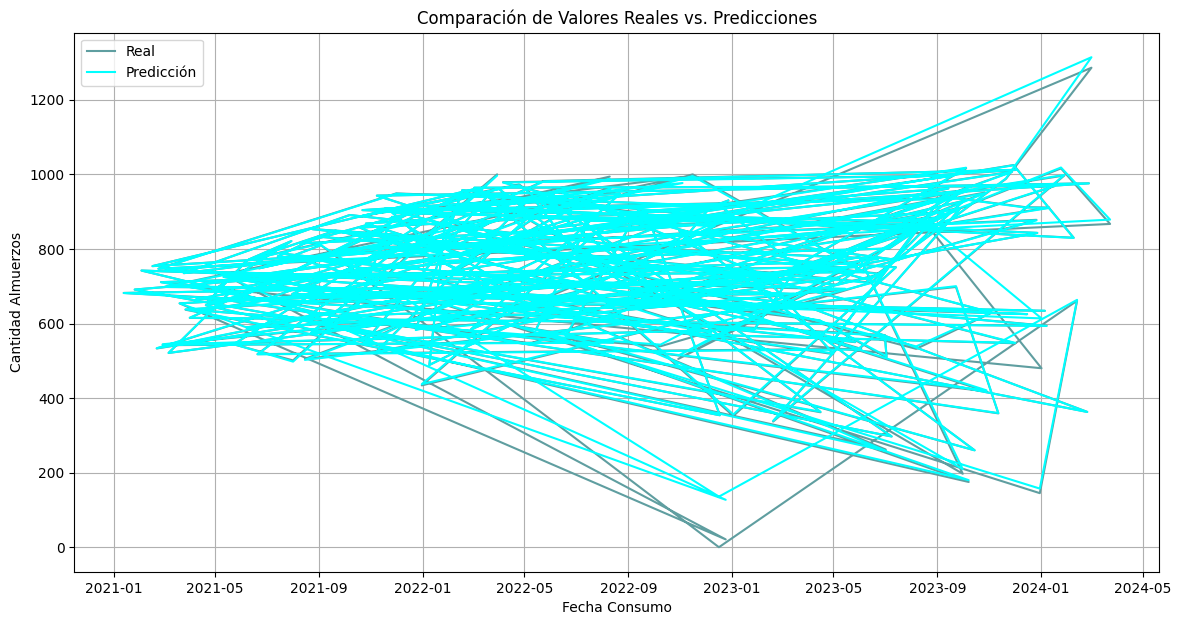

In [101]:
#Graficamos las predicciones para realizar un análisis visual, pero antes
#crearemos un dataframe para facilitar la visualización.
Resultados_SVM = pd.DataFrame({'Valores Reales': y_test, 'Predicciones': Predicciones_SVM}, index=y_test.index)

# Graficamos los valores reales versus las predicciones
plt.figure(figsize=(14, 7))
plt.plot(Resultados_SVM.index, Resultados_SVM['Valores Reales'], label='Real', color='cadetblue')
plt.plot(Resultados_SVM.index, Resultados_SVM['Predicciones'], label='Predicción', color='cyan')
plt.title('Comparación de Valores Reales vs. Predicciones')
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.legend()
plt.grid(True)
plt.show()

---

🔢**Métricas:** calcularemos a continuación las métricas MAE y WMAE para medir el desempeño de nuestro modelo SVM.

---

In [102]:
#Calculamos MAE
mae = mean_absolute_error(y_test, Predicciones_SVM)
#Calculamos WMAE definiendo inicialmente los pesos
weights = y_test
#Validamos que no existan valores NaN en los pesos
weights = weights.fillna(0)
#Realizamos el cálculo
wmae = np.sum(weights * np.abs(Predicciones_SVM - y_test)) / np.sum(weights)
print(f'****************************')
print(f'Métricas para el modelo SVM:')
print(f'****************************')
print(f'MAE: {mae}')
print(f'WMAE: {wmae}')

****************************
Métricas para el modelo SVM:
****************************
MAE: 2.8796714566188952
WMAE: 1.6410968775296177


In [ ]:
#Actualizamos las metricas obtenidas del modelo 6 en el dataframe
dfmetricas.at[5,'Valor 1'] = mae
dfmetricas.at[5,'Valor 2'] = wmae

In [103]:
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,214.475568,MBE,-3.084534
1,ARIMA,MAE,0.000000,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,0.000000,R2,0.000000
3,ARBOL DE REGRESIÓN,MSE,0.000000,R2,0.000000
4,REDES NEURONALES,MBE,0.000000,LOSS,0.000000
5,SVM,MAE,0.000000,WMAE,0.000000
